In [1]:
# coding: utf-8
# 2020/인공지능/final/학번/이름
import sys, os
import argparse
import time
import matplotlib.pyplot as plt
sys.path.append(os.pardir)

import numpy as np
from AReM import *
from model import *


class Trainer:
    """
    ex) 200개의 훈련데이터셋, 배치사이즈=5, 에폭=1000 일 경우 :
    40개의 배치(배치당 5개 데이터)를 에폭 갯수 만큼 업데이트 하는것.=
    (200 / 5) * 1000 = 40,000번 업데이트.

    ----------
    network : 네트워크
    x_train : 트레인 데이터
    t_train : 트레인 데이터에 대한 라벨
    x_test : 발리데이션 데이터
    t_test : 발리데이션 데이터에 대한 라벨
    epochs : 에폭 수
    mini_batch_size : 미니배치 사이즈
    learning_rate : 학습률
    verbose : 출력여부

    ----------
    """
    def __init__(self, network, x_train, t_train, x_test, t_test,
                 epochs=20, mini_batch_size=100,
                 learning_rate=0.01, verbose=True):
        self.network = network
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = int(epochs)
        self.batch_size = int(mini_batch_size)
        self.lr = learning_rate
        self.verbose = verbose
        self.train_size = x_train.shape[0]
        self.iter_per_epoch = int(max(self.train_size / self.batch_size, 1))
        self.max_iter = int(self.epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0

        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []
    
        self.max_acc = 0

    def train_step(self):
        # 렌덤 트레인 배치 생성
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]

        # 네트워크 업데이트
        self.network.update(x_batch, t_batch)
        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)

        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1

            train_acc, _ = self.accuracy(self.x_train, self.t_train)
            test_acc, _ = self.accuracy(self.x_test, self.t_test)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)
            
            if self.max_acc < test_acc:
                self.max_acc = test_acc
                self.max_params = {}
                for key, value in self.network.params.items():
                    self.max_params[key] = value.copy()
            
            if self.verbose: print(
                "=== epoch:", str(round(self.current_epoch, 3)), ", iteration:", str(round(self.current_iter, 3)),
                ", train acc:" + str(round(train_acc, 3)), ", test acc:" + str(round(test_acc, 3)), ", train loss:" + str(round(loss, 3)) + " ===")
        self.current_iter += 1

    def train(self):
        #학습 시작전  정확도 loss
        loss = self.network.loss(self.x_train, self.t_train)
        self.train_loss_list.append(loss)
        train_acc, _ = self.accuracy(self.x_train, self.t_train)
        test_acc, _ = self.accuracy(self.x_test, self.t_test)
        self.train_acc_list.append(train_acc)
        self.test_acc_list.append(test_acc)
        
        for i in range(self.max_iter):
            self.train_step()

        test_acc, inference_time = self.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc) + ", inference_time:" + str(inference_time))

    def accuracy(self, x, t):
        if t.ndim != 1: t = np.argmax(t, axis=1)

        acc = 0.0
        start_time = time.time()

#         for i in range(int(x.shape[0] / self.batch_size)):
#             tx = x[i * self.batch_size:(i + 1) * self.batch_size]
#             tt = t[i * self.batch_size:(i + 1) * self.batch_size]

#             y = self.network.predict(tx)
#             y = np.argmax(y, axis=1)
#             acc += np.sum(y == tt)
        
        y = self.network.predict(x)
        y = np.argmax(y,axis=1)
        acc += np.sum(y==t)
        
        
        inference_time = (time.time() - start_time) / x.shape[0]

        return acc / x.shape[0], inference_time


In [9]:

args = {
    "bs": 800,
    "epoch": 200,
    "sf" : "params.pkl",
    "lr" : 0.3
     }

# 데이터셋 탑재
(x_train, t_train), (x_test, t_test) = load_AReM(one_hot_label=False)
#(x_train, t_train), (x_test, t_test) = load_AReM(one_hot_label=False,standardze=True)

# x_t = np.concatenate((x_train,x_test))
# t_t = np.concatenate((t_train,t_test))


In [10]:
print(x_train.max(axis=0))
print(x_train.min(axis=0))
print(x_train.mean(axis=0))
print(x_train.std(axis=0))

[56.25 17.24 35.   11.42 39.   11.09]
[0. 0. 0. 0. 0. 0.]
[38.99815725  1.47474077 14.33255478  1.52033287 15.97623468  1.64322051]
[6.31303496 2.05340679 5.4094779  1.64276685 6.75185464 1.64559124]


In [4]:
# x_train = nomalize(x_train)
# x_test = nomalize(x_test)

In [5]:
network = Model()

# 트레이너 초기화
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=args['epoch'], mini_batch_size=args['bs'],
                  learning_rate=args['lr'], verbose=True)

# 트레이너를 사용해 모델 학습
trainer.train()

#파라미터 보관
network.save_params(args['sf'])
print("Network params Saved ")


=== epoch: 1 , iteration: 0 , train acc:0.3 , test acc:0.302 , train loss:1.627 ===
=== epoch: 2 , iteration: 41 , train acc:0.699 , test acc:0.702 , train loss:0.671 ===
=== epoch: 3 , iteration: 82 , train acc:0.723 , test acc:0.713 , train loss:0.618 ===
=== epoch: 4 , iteration: 123 , train acc:0.731 , test acc:0.723 , train loss:0.681 ===
=== epoch: 5 , iteration: 164 , train acc:0.739 , test acc:0.735 , train loss:0.597 ===
=== epoch: 6 , iteration: 205 , train acc:0.742 , test acc:0.74 , train loss:0.537 ===
=== epoch: 7 , iteration: 246 , train acc:0.747 , test acc:0.746 , train loss:0.58 ===
=== epoch: 8 , iteration: 287 , train acc:0.753 , test acc:0.751 , train loss:0.49 ===
=== epoch: 9 , iteration: 328 , train acc:0.762 , test acc:0.76 , train loss:0.507 ===
=== epoch: 10 , iteration: 369 , train acc:0.766 , test acc:0.76 , train loss:0.547 ===
=== epoch: 11 , iteration: 410 , train acc:0.765 , test acc:0.761 , train loss:0.512 ===
=== epoch: 12 , iteration: 451 , train ac

=== epoch: 93 , iteration: 3772 , train acc:0.816 , test acc:0.811 , train loss:0.441 ===
=== epoch: 94 , iteration: 3813 , train acc:0.816 , test acc:0.812 , train loss:0.406 ===
=== epoch: 95 , iteration: 3854 , train acc:0.812 , test acc:0.81 , train loss:0.439 ===
=== epoch: 96 , iteration: 3895 , train acc:0.816 , test acc:0.81 , train loss:0.434 ===
=== epoch: 97 , iteration: 3936 , train acc:0.812 , test acc:0.809 , train loss:0.38 ===
=== epoch: 98 , iteration: 3977 , train acc:0.81 , test acc:0.805 , train loss:0.414 ===
=== epoch: 99 , iteration: 4018 , train acc:0.815 , test acc:0.807 , train loss:0.435 ===
=== epoch: 100 , iteration: 4059 , train acc:0.807 , test acc:0.799 , train loss:0.435 ===
=== epoch: 101 , iteration: 4100 , train acc:0.813 , test acc:0.811 , train loss:0.382 ===
=== epoch: 102 , iteration: 4141 , train acc:0.816 , test acc:0.81 , train loss:0.385 ===
=== epoch: 103 , iteration: 4182 , train acc:0.814 , test acc:0.812 , train loss:0.437 ===
=== epoch: 

=== epoch: 184 , iteration: 7503 , train acc:0.822 , test acc:0.817 , train loss:0.43 ===
=== epoch: 185 , iteration: 7544 , train acc:0.825 , test acc:0.824 , train loss:0.389 ===
=== epoch: 186 , iteration: 7585 , train acc:0.825 , test acc:0.821 , train loss:0.373 ===
=== epoch: 187 , iteration: 7626 , train acc:0.821 , test acc:0.817 , train loss:0.374 ===
=== epoch: 188 , iteration: 7667 , train acc:0.824 , test acc:0.818 , train loss:0.38 ===
=== epoch: 189 , iteration: 7708 , train acc:0.823 , test acc:0.821 , train loss:0.385 ===
=== epoch: 190 , iteration: 7749 , train acc:0.827 , test acc:0.823 , train loss:0.38 ===
=== epoch: 191 , iteration: 7790 , train acc:0.821 , test acc:0.815 , train loss:0.405 ===
=== epoch: 192 , iteration: 7831 , train acc:0.821 , test acc:0.814 , train loss:0.468 ===
=== epoch: 193 , iteration: 7872 , train acc:0.827 , test acc:0.822 , train loss:0.372 ===
=== epoch: 194 , iteration: 7913 , train acc:0.823 , test acc:0.819 , train loss:0.366 ===
==

In [6]:
temparams = trainer.network.params

In [7]:
trainer.network.params = trainer.max_params
trainer.network.init_layer()
trainer.accuracy(x_test,t_test)

(0.8236139384504849, 3.6281249492043664e-06)

In [8]:
# trainer.network.params = temparams
# trainer.network.init_layer()
# trainer.accuracy(x_test,t_test)

In [22]:
network.save_params(args['sf'])
print("Network params Saved ")

Network params Saved 


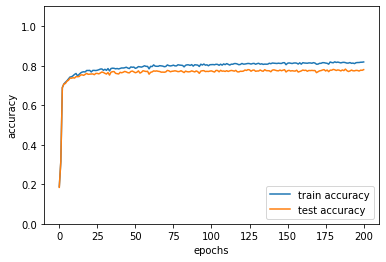

201

In [10]:
x = np.arange(len(trainer.train_acc_list))
plt.plot(x, trainer.train_acc_list, label='train accuracy')
plt.plot(x, trainer.test_acc_list, label='test accuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.1)
plt.legend(loc='lower right')
plt.show()

len(trainer.train_acc_list)

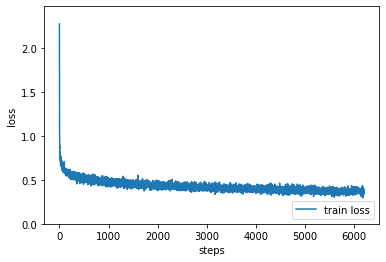

6201

In [47]:
x = np.arange(len(trainer.train_loss_list))
plt.plot(x, trainer.train_loss_list, label='train loss')
plt.xlabel("steps")
plt.ylabel("loss")
plt.ylim(0, max(trainer.train_loss_list) + 0.2)
plt.legend(loc='lower right')
plt.show()

len(trainer.train_loss_list)